Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 15.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.3 MB/s 
     |████████████████████████████████| 101 kB 12.9 MB/s 
     |████████████████████████████████| 6.6 MB 55.8 MB/s 
     |████████████████████████████████| 596 kB 84.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=baa9d1184bde17dc127a62fb00c70fbfa79aa2db33185e91ad6947a096c7d7a2
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1KL35Y4jz-za4VhiYyi9-wDsYb-_ES9Lg'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1IdJeCCcjeLt1H8vJNgWmgTFFfSnCUfZY'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1J4zNlfBAd1ng4GfyBabBM2EGjKreruBa'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  2253
Number of dev sentences:  138
Number of test sentences:  182
Number of words in the training dataset:  5994
Number of words in the dev dataset:  1008
Number of words in the test dataset:  1171
Tags in the training dataset: ['I-Apparatus-Unit', 'B-Apparatus-Descriptor', 'I-Synthesis-Apparatus', 'I-Brand', 'B-Number', 'B-Material-Descriptor', 'B-Amount-Unit', 'B-Synthesis-Apparatus', 'I-Condition-Type', 'B-Operation', 'I-Property-Misc', 'I-Amount-Unit', 'B-Property-Type', 'B-Meta', 'B-Property-Misc', 'B-Nonrecipe-Material', 'I-Apparatus-Descriptor', 'I-Number', 'I-Nonrecipe-Material', 'B-Material', 'I-Meta', 'B-Apparatus-Unit', 'I-Condition-Unit', 'I-Material', 'I-Material-Descriptor', 'O', 'B-Amount-Misc', 'I-Reference', 'I-Property-Type', 'I-Property-Unit', 'I-Operation', 'B-Property-Unit', 'B-Condition-Unit', 'I-Amount-Misc', 'B-Brand', 'I-Condition-Misc', 'B-Condition-Type', 'B-Characterization-Apparatus', 'I-Apparatus-Property-Type', 'B-Apparatus-

,Sentence #,Word,Tag
0,Sentence: 1,10.1016,O
1,Sentence: 1,/,O
2,Sentence: 1,j.carbon.2014.03.017,O
3,Sentence: 2,High,B-Property-Misc
4,Sentence: 2,-,I-Property-Misc
5,Sentence: 2,capacity,I-Property-Misc
6,Sentence: 2,graphene,B-Material
7,Sentence: 2,oxide,I-Material
8,Sentence: 2,/,I-Material
9,Sentence: 2,graphite,I-Material


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #100 
training_sentences[100]

[('The', 'O'),
 ('obtained', 'O'),
 ('precursor', 'B-Material'),
 ('powder', 'B-Material-Descriptor'),
 ('was', 'O'),
 ('dried', 'B-Operation'),
 ('at', 'O'),
 ('120', 'B-Number'),
 ('degC', 'B-Condition-Unit'),
 ('for', 'O'),
 ('2', 'B-Number'),
 ('h', 'B-Condition-Unit'),
 ('and', 'O'),
 ('then', 'O'),
 ('calcined', 'B-Operation'),
 ('at', 'O'),
 ('700', 'B-Number'),
 ('degC', 'B-Condition-Unit'),
 ('for', 'O'),
 ('2', 'B-Number'),
 ('h', 'B-Condition-Unit'),
 ('.', 'O')]

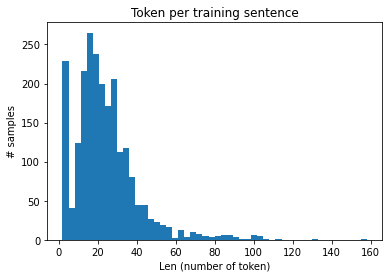

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

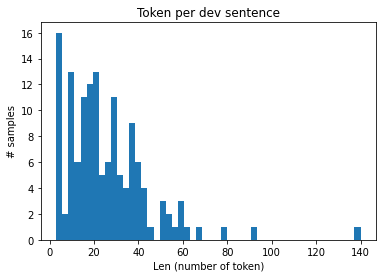

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

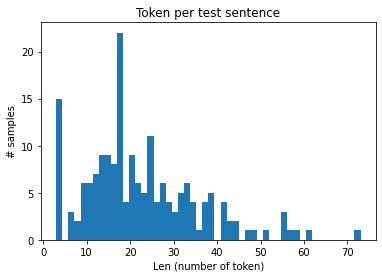

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'ethanol'
print(word2idx['ethanol'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-Material'
print(tag2idx['B-Material'])
# Tag of index 4
print(idx2tag[4])

341
c5ta03565a
19
B-Number


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.5)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 2253
Points in y_train before removal: 2253
Points in X_train before removal: 1126
Points in y_train before removal: 1126


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[3708, 1827, 3941, 28, 3532, 1195, 2073, 6293, 4631, 3244, 977, 2429, 2040, 1343, 5111, 2040, 5034, 3539]
[14, 25, 19, 25, 25, 25, 25, 25, 25, 14, 25, 25, 25, 25, 25, 25, 25, 25]
[2085, 973, 4967]
[25, 25, 25]
[2085, 973, 6512]
[25, 25, 25]
341
c5ta03565a
19
B-Number
6535
43


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.9 MB/s 
     |████████████████████████████████| 6.6 MB 75.1 MB/s 
     |████████████████████████████████| 120 kB 94.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.3 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=1f757c2d37ff07b6a50c29675ca61790d0c6c91ae5636bd3584c42ffb4ad4bb3
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[3708, 1827, 3941, 28, 3532, 1195, 2073, 6293, 4631, 3244,

In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 32:
    TRAIN_BATCH_SIZE = 32
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 32:
    VALID_BATCH_SIZE = 32
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [9]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1126
Points in y_train after augmentation: 1126
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.122230529785156
Training loss epoch: 1.2442666225963168
Training accuracy epoch: 0.7192578301132619
Validating model...
Validation Loss: 0.6926078736782074
Validation Accuracy: 0.830986584445221
Training epoch: 2
Training loss per 100 training steps: 0.4993518590927124
Training loss epoch: 0.5018366749087969
Training accuracy epoch: 0.8631914263322378
Validating model...
Validation Loss: 0.5116170227527619
Validation Accuracy: 0.8572887708681144
Training epoch: 3
Training loss per 100 training steps: 0.32325032353401184
Training loss epoch: 0.33405688115292126
Training accuracy epoch: 0.9026795123703624
Validating model...
Validation Loss: 0.44546574354171753
Validation Accuracy: 0.8635409343353047
Training epoch: 4
Training loss per 100 training steps: 0.2679814398288727
Training loss epoch: 0.23217938281595707
Training accuracy epoch: 0.9303213061076602
Validating model...
Validation Loss: 0.4933666229248047
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4854612717261681
Validation Accuracy: 0.8579119063706445
Validation duration: 0.01172873333333347 minutes
F1-score (test): 78.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.87      0.95      0.91        98
      Apparatus-Descriptor       0.50      0.78      0.61         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.46      0.57        13
                     Brand       0.52      0.63      0.57        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.56      0.90      0.69        20
            Condition-Type       0.50      1.00      0.67         1
            Condition-Unit       0.91      0.97      0.94        87
                  Material       0.74      0.90      0.81       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.968090057373047
Training loss epoch: 1.2267515626218584
Training accuracy epoch: 0.7227211646593973
Validating model...
Validation Loss: 0.6877695202827454
Validation Accuracy: 0.8249637298919916
Training epoch: 2
Training loss per 100 training steps: 0.6388657093048096
Training loss epoch: 0.5096371728512976
Training accuracy epoch: 0.8604170812259425
Validating model...
Validation Loss: 0.46921525299549105
Validation Accuracy: 0.8667804163937056
Training epoch: 3
Training loss per 100 training steps: 0.2506211996078491
Training loss epoch: 0.322410942779647
Training accuracy epoch: 0.9078628115679219
Validating model...
Validation Loss: 0.4478446990251541
Validation Accuracy: 0.866291452516027
Training epoch: 4
Training loss per 100 training steps: 0.24011988937854767
Training loss epoch: 0.2325450662109587
Training accuracy epoch: 0.9304834031157713
Validating model...
Validation Loss: 0.5125401943922043
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4883031134422009
Validation Accuracy: 0.8566334556402455
Validation duration: 0.011904400000000237 minutes
F1-score (test): 77.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.88      0.96      0.92        98
      Apparatus-Descriptor       0.54      0.78      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       0.17      0.09      0.12        11
            Condition-Misc       0.59      0.95      0.73        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.73      0.88      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.278483867645264
Training loss epoch: 1.2667503265870943
Training accuracy epoch: 0.7124951093311249
Validating model...
Validation Loss: 0.6975338280200958
Validation Accuracy: 0.8233029280736222
Training epoch: 2
Training loss per 100 training steps: 0.5600233674049377
Training loss epoch: 0.5333522285024325
Training accuracy epoch: 0.8574857363996345
Validating model...
Validation Loss: 0.5209291100502014
Validation Accuracy: 0.8551912271393484
Training epoch: 3
Training loss per 100 training steps: 0.3600126802921295
Training loss epoch: 0.343586796687709
Training accuracy epoch: 0.9012730534765784
Validating model...
Validation Loss: 0.4631246030330658
Validation Accuracy: 0.8650038385877965
Training epoch: 4
Training loss per 100 training steps: 0.20194685459136963
Training loss epoch: 0.22912913291818565
Training accuracy epoch: 0.9323879380685663
Validating model...
Validation Loss: 0.4663802534341812
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47947739408566403
Validation Accuracy: 0.8565293597060095
Validation duration: 0.011329566666666816 minutes
F1-score (test): 77.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.86      0.95      0.90        98
      Apparatus-Descriptor       0.40      0.67      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.72      0.85      0.78        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.61      0.95      0.75        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.74      0.91      0.82       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.7913947105407715
Training loss epoch: 1.2399755368630092
Training accuracy epoch: 0.7199187185916736
Validating model...
Validation Loss: 0.6912971794605255
Validation Accuracy: 0.8263839477739078
Training epoch: 2
Training loss per 100 training steps: 0.635216236114502
Training loss epoch: 0.4939938262104988
Training accuracy epoch: 0.8664895374615614
Validating model...
Validation Loss: 0.4659057676792145
Validation Accuracy: 0.8612939411536817
Training epoch: 3
Training loss per 100 training steps: 0.2637796401977539
Training loss epoch: 0.32931675927506554
Training accuracy epoch: 0.9028919842858552
Validating model...
Validation Loss: 0.5141406953334808
Validation Accuracy: 0.8527565370009931
Training epoch: 4
Training loss per 100 training steps: 0.2032596915960312
Training loss epoch: 0.24435311555862427
Training accuracy epoch: 0.9261122825747375
Validating model...
Validation Loss: 0.48898486495018006
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4934397225196545
Validation Accuracy: 0.8496440980001563
Validation duration: 0.011762083333333824 minutes
F1-score (test): 77.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.82      0.90      0.86        98
      Apparatus-Descriptor       0.50      0.44      0.47         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.55      0.46      0.50        13
                     Brand       0.59      0.70      0.64        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.73      0.80      0.76        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.95      0.92        87
                  Material       0.71      0.87      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.957257032394409
Training loss epoch: 1.2405279394653108
Training accuracy epoch: 0.7214249950442503
Validating model...
Validation Loss: 0.7005200445652008
Validation Accuracy: 0.8271458585079833
Training epoch: 2
Training loss per 100 training steps: 0.6473782062530518
Training loss epoch: 0.5059416211313672
Training accuracy epoch: 0.8629264514321645
Validating model...
Validation Loss: 0.5103424578905106
Validation Accuracy: 0.8595258091047601
Training epoch: 3
Training loss per 100 training steps: 0.3674503564834595
Training loss epoch: 0.33872320213251644
Training accuracy epoch: 0.9008231788470733
Validating model...
Validation Loss: 0.46590325236320496
Validation Accuracy: 0.8696760108279109
Training epoch: 4
Training loss per 100 training steps: 0.24438804388046265
Training loss epoch: 0.22920567956235674
Training accuracy epoch: 0.9334612962866884
Validating model...
Validation Loss: 0.470504230260849
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.506698917884093
Validation Accuracy: 0.8516117571286835
Validation duration: 0.011818233333333221 minutes
F1-score (test): 76.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.89      0.94      0.92        98
      Apparatus-Descriptor       0.41      0.78      0.54         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.56      0.70      0.62        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.51      0.95      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.95      0.92        87
                  Material       0.72      0.89      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.948436737060547
Training loss epoch: 1.2085302472114563
Training accuracy epoch: 0.7256777762209697
Validating model...
Validation Loss: 0.6793311268091202
Validation Accuracy: 0.8330834374699714
Training epoch: 2
Training loss per 100 training steps: 0.7179405689239502
Training loss epoch: 0.49164087656471467
Training accuracy epoch: 0.8686654016381965
Validating model...
Validation Loss: 0.49373460114002227
Validation Accuracy: 0.8629529921660621
Training epoch: 3
Training loss per 100 training steps: 0.3800238072872162
Training loss epoch: 0.3351328621308009
Training accuracy epoch: 0.90319518496989
Validating model...
Validation Loss: 0.4755974501371384
Validation Accuracy: 0.8597493716174529
Training epoch: 4
Training loss per 100 training steps: 0.31380555033683777
Training loss epoch: 0.23948845225903723
Training accuracy epoch: 0.9274661714080867
Validating model...
Validation Loss: 0.46844678819179536
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48384161637379575
Validation Accuracy: 0.864003928059947
Validation duration: 0.013166916666667325 minutes
F1-score (test): 78.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.89      0.95      0.92        98
      Apparatus-Descriptor       0.47      0.78      0.58         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.47      0.54      0.50        13
                     Brand       0.79      0.85      0.82        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.61      0.95      0.75        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.98      0.94        87
                  Material       0.76      0.87      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.933856725692749
Training loss epoch: 1.2417938742372725
Training accuracy epoch: 0.7180184751298984
Validating model...
Validation Loss: 0.6843723773956298
Validation Accuracy: 0.8249763501339908
Training epoch: 2
Training loss per 100 training steps: 0.49209535121917725
Training loss epoch: 0.501891745461358
Training accuracy epoch: 0.8630356424753485
Validating model...
Validation Loss: 0.48339741230010985
Validation Accuracy: 0.864104190710561
Training epoch: 3
Training loss per 100 training steps: 0.2114521563053131
Training loss epoch: 0.31405805568728185
Training accuracy epoch: 0.9076270602217316
Validating model...
Validation Loss: 0.5106536954641342
Validation Accuracy: 0.863639089910666
Training epoch: 4
Training loss per 100 training steps: 0.26412609219551086
Training loss epoch: 0.24443495232197973
Training accuracy epoch: 0.9250132661020741
Validating model...
Validation Loss: 0.4998105615377426
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4873255491256714
Validation Accuracy: 0.8598219058097881
Validation duration: 0.012712633333334604 minutes
F1-score (test): 77.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.14      0.20         7
               Amount-Unit       0.86      0.94      0.90        98
      Apparatus-Descriptor       0.38      0.33      0.35         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       1.00      0.23      0.38        13
                     Brand       0.60      0.67      0.63        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.59      0.95      0.73        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.73      0.87      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.895252227783203
Training loss epoch: 1.2202844536966748
Training accuracy epoch: 0.7206327938083477
Validating model...
Validation Loss: 0.6731969177722931
Validation Accuracy: 0.8278524540607485
Training epoch: 2
Training loss per 100 training steps: 0.6599316596984863
Training loss epoch: 0.49658995535638595
Training accuracy epoch: 0.8656800187377653
Validating model...
Validation Loss: 0.4888304054737091
Validation Accuracy: 0.8606819804685804
Training epoch: 3
Training loss per 100 training steps: 0.37921544909477234
Training loss epoch: 0.33390627966986763
Training accuracy epoch: 0.9044489531854083
Validating model...
Validation Loss: 0.49978125691413877
Validation Accuracy: 0.8545480366429212
Training epoch: 4
Training loss per 100 training steps: 0.17644092440605164
Training loss epoch: 0.2365815175904168
Training accuracy epoch: 0.9280253627370865
Validating model...
Validation Loss: 0.4788204252719879
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5072369529650762
Validation Accuracy: 0.8539782035294756
Validation duration: 0.011823499999998906 minutes
F1-score (test): 77.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.86      0.95      0.90        98
      Apparatus-Descriptor       0.41      0.78      0.54         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.38      0.43        13
                     Brand       0.67      0.74      0.70        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.57      1.00      0.73        20
            Condition-Type       0.08      1.00      0.14         1
            Condition-Unit       0.89      0.97      0.93        87
                  Material       0.74      0.88      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.919987440109253
Training loss epoch: 1.2470239020056195
Training accuracy epoch: 0.7214110565203103
Validating model...
Validation Loss: 0.6998635351657867
Validation Accuracy: 0.8265847436501478
Training epoch: 2
Training loss per 100 training steps: 0.6665974855422974
Training loss epoch: 0.521833265821139
Training accuracy epoch: 0.8592735692921829
Validating model...
Validation Loss: 0.48313685655593874
Validation Accuracy: 0.862402579100355
Training epoch: 3
Training loss per 100 training steps: 0.41939783096313477
Training loss epoch: 0.3315125157435735
Training accuracy epoch: 0.9025641495516395
Validating model...
Validation Loss: 0.44538748264312744
Validation Accuracy: 0.8620165724333189
Training epoch: 4
Training loss per 100 training steps: 0.204233780503273
Training loss epoch: 0.23875593807962206
Training accuracy epoch: 0.9274832726754441
Validating model...
Validation Loss: 0.4704883754253387
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5165404516917008
Validation Accuracy: 0.8519818685951386
Validation duration: 0.011858766666667483 minutes
F1-score (test): 77.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.11      0.14      0.12         7
               Amount-Unit       0.85      0.94      0.89        98
      Apparatus-Descriptor       0.50      0.56      0.53         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.54      0.58        13
                     Brand       0.52      0.59      0.55        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.58      0.90      0.71        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.97      0.93        87
                  Material       0.71      0.91      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.848377227783203
Training loss epoch: 1.2273207240634494
Training accuracy epoch: 0.7262818069613075
Validating model...
Validation Loss: 0.6994721382856369
Validation Accuracy: 0.8150477191990818
Training epoch: 2
Training loss per 100 training steps: 0.7271697521209717
Training loss epoch: 0.5163311254647043
Training accuracy epoch: 0.8624431821820931
Validating model...
Validation Loss: 0.5002902865409851
Validation Accuracy: 0.8589115421216293
Training epoch: 3
Training loss per 100 training steps: 0.2318306714296341
Training loss epoch: 0.33980713081028724
Training accuracy epoch: 0.9016744376978212
Validating model...
Validation Loss: 0.4726093947887421
Validation Accuracy: 0.8600941059009125
Training epoch: 4
Training loss per 100 training steps: 0.2015591859817505
Training loss epoch: 0.2381970766517851
Training accuracy epoch: 0.9296704222062169
Validating model...
Validation Loss: 0.48141204118728637
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47341334361296433
Validation Accuracy: 0.8566948967140369
Validation duration: 0.011810766666667406 minutes
F1-score (test): 77.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.89      0.95      0.92        98
      Apparatus-Descriptor       0.47      0.78      0.58         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.78      0.54      0.64        13
                     Brand       0.68      0.78      0.72        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.53      0.95      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.72      0.90      0.80       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7556238174438477
Training loss epoch: 1.139396445317702
Training accuracy epoch: 0.736409180565018
Validating model...
Validation Loss: 0.6359077334403992
Validation Accuracy: 0.8320562190267802
Training epoch: 2
Training loss per 100 training steps: 0.49104979634284973
Training loss epoch: 0.4602749391712926
Training accuracy epoch: 0.872370752164461
Validating model...
Validation Loss: 0.48740577399730683
Validation Accuracy: 0.8610610153777067
Training epoch: 3
Training loss per 100 training steps: 0.42161548137664795
Training loss epoch: 0.2924019386145202
Training accuracy epoch: 0.9146515998140291
Validating model...
Validation Loss: 0.4753434151411057
Validation Accuracy: 0.8627484315583869
Training epoch: 4
Training loss per 100 training steps: 0.14182010293006897
Training loss epoch: 0.19627184894951907
Training accuracy epoch: 0.9422518057322435
Validating model...
Validation Loss: 0.5020267605781555
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49387113176859343
Validation Accuracy: 0.8553086567548144
Validation duration: 0.011253200000000636 minutes
F1-score (test): 78.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.81      0.90      0.85        98
      Apparatus-Descriptor       0.39      0.78      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.77      0.74      0.75        27
Characterization-Apparatus       0.09      0.09      0.09        11
            Condition-Misc       0.51      0.95      0.67        20
            Condition-Type       0.09      1.00      0.17         1
            Condition-Unit       0.91      0.97      0.94        87
                  Material       0.77      0.90      0.83       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8614141941070557
Training loss epoch: 1.1156861754980953
Training accuracy epoch: 0.7424015023072706
Validating model...
Validation Loss: 0.5977629065513611
Validation Accuracy: 0.8414064666572919
Training epoch: 2
Training loss per 100 training steps: 0.5333726406097412
Training loss epoch: 0.4517524242401123
Training accuracy epoch: 0.8753484411859013
Validating model...
Validation Loss: 0.484913644194603
Validation Accuracy: 0.8625685237919672
Training epoch: 3
Training loss per 100 training steps: 0.3775631785392761
Training loss epoch: 0.2839804003861817
Training accuracy epoch: 0.9165903842988037
Validating model...
Validation Loss: 0.4795076370239258
Validation Accuracy: 0.8645580246053909
Training epoch: 4
Training loss per 100 training steps: 0.1563396006822586
Training loss epoch: 0.18922820602628318
Training accuracy epoch: 0.9428255488106345
Validating model...
Validation Loss: 0.4940031498670578
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49393876928549546
Validation Accuracy: 0.8529728860014649
Validation duration: 0.011291533333333822 minutes
F1-score (test): 77.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.43      0.43      0.43         7
               Amount-Unit       0.82      0.92      0.87        98
      Apparatus-Descriptor       0.50      0.67      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.81      0.81      0.81        27
Characterization-Apparatus       0.23      0.27      0.25        11
            Condition-Misc       0.57      1.00      0.73        20
            Condition-Type       0.09      1.00      0.17         1
            Condition-Unit       0.90      0.99      0.94        87
                  Material       0.74      0.88      0.81       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.992377519607544
Training loss epoch: 1.1534518640149722
Training accuracy epoch: 0.7372321847038308
Validating model...
Validation Loss: 0.6518570899963378
Validation Accuracy: 0.8276666674868085
Training epoch: 2
Training loss per 100 training steps: 0.7516469359397888
Training loss epoch: 0.4615884321657094
Training accuracy epoch: 0.8727967023325847
Validating model...
Validation Loss: 0.5201686143875122
Validation Accuracy: 0.8579268099787927
Training epoch: 3
Training loss per 100 training steps: 0.3572644889354706
Training loss epoch: 0.30129166319966316
Training accuracy epoch: 0.9116952541669758
Validating model...
Validation Loss: 0.490026992559433
Validation Accuracy: 0.8601252709540799
Training epoch: 4
Training loss per 100 training steps: 0.19139157235622406
Training loss epoch: 0.20205783589997076
Training accuracy epoch: 0.9408419398969774
Validating model...
Validation Loss: 0.48772628605365753
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5091586296374981
Validation Accuracy: 0.851181427002879
Validation duration: 0.011337216666667397 minutes
F1-score (test): 76.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.88      0.93      0.91        98
      Apparatus-Descriptor       0.54      0.78      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.58      0.54      0.56        13
                     Brand       0.52      0.59      0.55        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.64      0.90      0.75        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.92      0.93      0.93        87
                  Material       0.73      0.84      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.95344614982605
Training loss epoch: 1.188488538969647
Training accuracy epoch: 0.7284591389490932
Validating model...
Validation Loss: 0.6342347145080567
Validation Accuracy: 0.8343274926710993
Training epoch: 2
Training loss per 100 training steps: 0.5433752536773682
Training loss epoch: 0.4648617092858661
Training accuracy epoch: 0.8727055896154685
Validating model...
Validation Loss: 0.5008282840251923
Validation Accuracy: 0.8654155982552888
Training epoch: 3
Training loss per 100 training steps: 0.3254150450229645
Training loss epoch: 0.29129262133078143
Training accuracy epoch: 0.9159728811554174
Validating model...
Validation Loss: 0.4809857368469238
Validation Accuracy: 0.8534915766378635
Training epoch: 4
Training loss per 100 training steps: 0.19180743396282196
Training loss epoch: 0.19281057979572902
Training accuracy epoch: 0.944064900570984
Validating model...
Validation Loss: 0.5225001096725463
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49778035283088684
Validation Accuracy: 0.8588450507283961
Validation duration: 0.012761416666667932 minutes
F1-score (test): 77.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.87      0.92      0.90        98
      Apparatus-Descriptor       0.44      0.78      0.56         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.59      0.80      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.98      0.95        87
                  Material       0.74      0.87      0.80       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.0396246910095215
Training loss epoch: 1.1560987139290029
Training accuracy epoch: 0.7314997885195414
Validating model...
Validation Loss: 0.6540865391492844
Validation Accuracy: 0.8315097900580846
Training epoch: 2
Training loss per 100 training steps: 0.572032630443573
Training loss epoch: 0.4961450736631047
Training accuracy epoch: 0.8634822138773335
Validating model...
Validation Loss: 0.48884383738040926
Validation Accuracy: 0.8661570203590866
Training epoch: 3
Training loss per 100 training steps: 0.3436475396156311
Training loss epoch: 0.32024145261807874
Training accuracy epoch: 0.9050333692498401
Validating model...
Validation Loss: 0.456788195669651
Validation Accuracy: 0.8682374875276008
Training epoch: 4
Training loss per 100 training steps: 0.2251705378293991
Training loss epoch: 0.21504278447140346
Training accuracy epoch: 0.9351231219223329
Validating model...
Validation Loss: 0.49877758473157885
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4565350848894853
Validation Accuracy: 0.8657890403471159
Validation duration: 0.011265016666667786 minutes
F1-score (test): 78.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.91      0.95      0.93        98
      Apparatus-Descriptor       0.50      0.78      0.61         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.65      0.74      0.69        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.67      0.90      0.77        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.74      0.86      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.887586832046509
Training loss epoch: 1.1608250588178635
Training accuracy epoch: 0.7321669962813228
Validating model...
Validation Loss: 0.6516317844390869
Validation Accuracy: 0.830179206189476
Training epoch: 2
Training loss per 100 training steps: 0.6054911017417908
Training loss epoch: 0.4725594148039818
Training accuracy epoch: 0.8715471960094008
Validating model...
Validation Loss: 0.47801280617713926
Validation Accuracy: 0.8595607589958743
Training epoch: 3
Training loss per 100 training steps: 0.3164741098880768
Training loss epoch: 0.3023824021220207
Training accuracy epoch: 0.9127552828550779
Validating model...
Validation Loss: 0.4668241113424301
Validation Accuracy: 0.85993058115181
Training epoch: 4
Training loss per 100 training steps: 0.20216523110866547
Training loss epoch: 0.20652819831262936
Training accuracy epoch: 0.9382511357794303
Validating model...
Validation Loss: 0.4762426257133484
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5193379062872666
Validation Accuracy: 0.8520566146818594
Validation duration: 0.011357416666669451 minutes
F1-score (test): 77.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.88      0.94      0.91        98
      Apparatus-Descriptor       0.43      0.67      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.56      0.95      0.70        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.98      0.95        87
                  Material       0.72      0.90      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9705092906951904
Training loss epoch: 1.184520049528642
Training accuracy epoch: 0.7279198707000248
Validating model...
Validation Loss: 0.6336638689041137
Validation Accuracy: 0.8276999202762825
Training epoch: 2
Training loss per 100 training steps: 0.5730640292167664
Training loss epoch: 0.4755196964198893
Training accuracy epoch: 0.8704736378290826
Validating model...
Validation Loss: 0.49153065085411074
Validation Accuracy: 0.8571271182235147
Training epoch: 3
Training loss per 100 training steps: 0.3359977602958679
Training loss epoch: 0.3107769445262172
Training accuracy epoch: 0.9076411250821882
Validating model...
Validation Loss: 0.4757826000452042
Validation Accuracy: 0.8656573256948837
Training epoch: 4
Training loss per 100 training steps: 0.13158047199249268
Training loss epoch: 0.20873805914412846
Training accuracy epoch: 0.9383825025978149
Validating model...
Validation Loss: 0.5294344604015351
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48223330539006454
Validation Accuracy: 0.8640751451372387
Validation duration: 0.011392733333332216 minutes
F1-score (test): 78.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.43      0.43      0.43         7
               Amount-Unit       0.92      0.94      0.93        98
      Apparatus-Descriptor       0.80      0.44      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.64      0.78      0.70        27
Characterization-Apparatus       0.17      0.18      0.17        11
            Condition-Misc       0.60      0.90      0.72        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.74      0.92      0.82       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.06059455871582
Training loss epoch: 1.1845648342912847
Training accuracy epoch: 0.7290181935849038
Validating model...
Validation Loss: 0.6382365942001342
Validation Accuracy: 0.8340949929318171
Training epoch: 2
Training loss per 100 training steps: 0.556566059589386
Training loss epoch: 0.4701900136741725
Training accuracy epoch: 0.8703803651451371
Validating model...
Validation Loss: 0.4780019074678421
Validation Accuracy: 0.861141946901418
Training epoch: 3
Training loss per 100 training steps: 0.3938361704349518
Training loss epoch: 0.2976703748784282
Training accuracy epoch: 0.9131780961901051
Validating model...
Validation Loss: 0.47118677794933317
Validation Accuracy: 0.8696706281857832
Training epoch: 4
Training loss per 100 training steps: 0.17292584478855133
Training loss epoch: 0.1983063051646406
Training accuracy epoch: 0.941660479287362
Validating model...
Validation Loss: 0.49138049185276034
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5600366363158593
Validation Accuracy: 0.850369289312492
Validation duration: 0.011330750000001898 minutes
F1-score (test): 77.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.85      0.94      0.89        98
      Apparatus-Descriptor       0.40      0.67      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.79      0.81      0.80        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.54      0.95      0.69        20
            Condition-Type       0.12      1.00      0.22         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.72      0.91      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.802244186401367
Training loss epoch: 1.132281675257466
Training accuracy epoch: 0.7417893527950272
Validating model...
Validation Loss: 0.6278343588113785
Validation Accuracy: 0.8432096103620804
Training epoch: 2
Training loss per 100 training steps: 0.5616511106491089
Training loss epoch: 0.4791744520718401
Training accuracy epoch: 0.8690218452975618
Validating model...
Validation Loss: 0.504038518667221
Validation Accuracy: 0.8576400821802024
Training epoch: 3
Training loss per 100 training steps: 0.3015463352203369
Training loss epoch: 0.32046921652826393
Training accuracy epoch: 0.9068260082853846
Validating model...
Validation Loss: 0.4636350691318512
Validation Accuracy: 0.8762424484771868
Training epoch: 4
Training loss per 100 training steps: 0.2555333077907562
Training loss epoch: 0.22530564733526923
Training accuracy epoch: 0.9309049303374478
Validating model...
Validation Loss: 0.5216087460517883
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48992273899225086
Validation Accuracy: 0.861264786872041
Validation duration: 0.011375200000001466 minutes
F1-score (test): 78.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.86      0.94      0.90        98
      Apparatus-Descriptor       0.50      0.78      0.61         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.57      1.00      0.73        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.99      0.94        87
                  Material       0.73      0.87      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1408
Points in y_train after augmentation: 1408
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9641873836517334
Training loss epoch: 1.1687836809591814
Training accuracy epoch: 0.7338916943156573
Validating model...
Validation Loss: 0.6458828926086426
Validation Accuracy: 0.835209045712887
Training epoch: 2
Training loss per 100 training steps: 0.5247881412506104
Training loss epoch: 0.48265976391055365
Training accuracy epoch: 0.8679536473545452
Validating model...
Validation Loss: 0.47501777708530424
Validation Accuracy: 0.8717262280007929
Training epoch: 3
Training loss per 100 training steps: 0.3618584871292114
Training loss epoch: 0.31346379152753134
Training accuracy epoch: 0.9104219203018379
Validating model...
Validation Loss: 0.4468031287193298
Validation Accuracy: 0.8680203975876444
Training epoch: 4
Training loss per 100 training steps: 0.2391468584537506
Training loss epoch: 0.2146538912572644
Training accuracy epoch: 0.9372032857146693
Validating model...
Validation Loss: 0.48268560618162154
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4665969174641829
Validation Accuracy: 0.8586370880200351
Validation duration: 0.011394900000000992 minutes
F1-score (test): 77.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.87      0.94      0.90        98
      Apparatus-Descriptor       0.54      0.78      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.86      0.46      0.60        13
                     Brand       0.69      0.81      0.75        27
Characterization-Apparatus       0.11      0.09      0.10        11
            Condition-Misc       0.64      0.90      0.75        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.74      0.88      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [11]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.874265193939209
Training loss epoch: 1.0955034674338575
Training accuracy epoch: 0.7470162624956691
Validating model...
Validation Loss: 0.5960000336170197
Validation Accuracy: 0.8417175142971078
Training epoch: 2
Training loss per 100 training steps: 0.46995478868484497
Training loss epoch: 0.435379295978906
Training accuracy epoch: 0.8796884972903513
Validating model...
Validation Loss: 0.46859149932861327
Validation Accuracy: 0.8632219715192203
Training epoch: 3
Training loss per 100 training steps: 0.35133129358291626
Training loss epoch: 0.2724785363336779
Training accuracy epoch: 0.9169852158734235
Validating model...
Validation Loss: 0.46077456772327424
Validation Accuracy: 0.8670319834827209
Training epoch: 4
Training loss per 100 training steps: 0.21129342913627625
Training loss epoch: 0.1670935387318989
Training accuracy epoch: 0.9509823564639819
Validating model...
Validation Loss: 0.5085401326417923
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48151395183343154
Validation Accuracy: 0.8550832472618879
Validation duration: 0.011361366666668952 minutes
F1-score (test): 77.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.88      0.94      0.91        98
      Apparatus-Descriptor       0.47      0.78      0.58         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.54      0.54      0.54        13
                     Brand       0.68      0.70      0.69        27
Characterization-Apparatus       0.33      0.18      0.24        11
            Condition-Misc       0.58      0.95      0.72        20
            Condition-Type       0.12      1.00      0.22         1
            Condition-Unit       0.89      0.95      0.92        87
                  Material       0.77      0.85      0.81       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.765197515487671
Training loss epoch: 1.0549558879069563
Training accuracy epoch: 0.7577693711291688
Validating model...
Validation Loss: 0.5965687453746795
Validation Accuracy: 0.8372066487480829
Training epoch: 2
Training loss per 100 training steps: 0.5020699501037598
Training loss epoch: 0.43051255873914035
Training accuracy epoch: 0.8809386175983887
Validating model...
Validation Loss: 0.4805319309234619
Validation Accuracy: 0.8609507356142337
Training epoch: 3
Training loss per 100 training steps: 0.28450557589530945
Training loss epoch: 0.27721414447955367
Training accuracy epoch: 0.9180195751244592
Validating model...
Validation Loss: 0.47967003285884857
Validation Accuracy: 0.8617344105163367
Training epoch: 4
Training loss per 100 training steps: 0.1434471607208252
Training loss epoch: 0.1821864718255007
Training accuracy epoch: 0.946309248276031
Validating model...
Validation Loss: 0.49920450150966644
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5307688804773184
Validation Accuracy: 0.8487127241477983
Validation duration: 0.011273966666666031 minutes
F1-score (test): 77.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.86      0.95      0.90        98
      Apparatus-Descriptor       0.40      0.67      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.47      0.63      0.54        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.42      0.95      0.58        20
            Condition-Type       0.09      1.00      0.17         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.72      0.90      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.936173915863037
Training loss epoch: 1.0486125844829488
Training accuracy epoch: 0.7571348439166933
Validating model...
Validation Loss: 0.5727576851844788
Validation Accuracy: 0.8487694441416588
Training epoch: 2
Training loss per 100 training steps: 0.4794408977031708
Training loss epoch: 0.4026133485560147
Training accuracy epoch: 0.886288617038697
Validating model...
Validation Loss: 0.47651261240243914
Validation Accuracy: 0.8575067149965288
Training epoch: 3
Training loss per 100 training steps: 0.3531326651573181
Training loss epoch: 0.24749435681217122
Training accuracy epoch: 0.927685014012216
Validating model...
Validation Loss: 0.4532443583011627
Validation Accuracy: 0.870164412429643
Training epoch: 4
Training loss per 100 training steps: 0.13500764966011047
Training loss epoch: 0.15576942981976383
Training accuracy epoch: 0.9549835180941739
Validating model...
Validation Loss: 0.4947489395737648
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5188642556850727
Validation Accuracy: 0.8542087131697509
Validation duration: 0.011309350000002875 minutes
F1-score (test): 78.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.90      0.96      0.93        98
      Apparatus-Descriptor       0.41      0.78      0.54         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.62      0.64        13
                     Brand       0.66      0.70      0.68        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.53      1.00      0.69        20
            Condition-Type       0.09      1.00      0.17         1
            Condition-Unit       0.90      0.97      0.93        87
                  Material       0.75      0.90      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.6569788455963135
Training loss epoch: 1.0338026313286908
Training accuracy epoch: 0.7587786239378749
Validating model...
Validation Loss: 0.5708869338035584
Validation Accuracy: 0.847869224413978
Training epoch: 2
Training loss per 100 training steps: 0.45783767104148865
Training loss epoch: 0.414271779498964
Training accuracy epoch: 0.8836791462630968
Validating model...
Validation Loss: 0.46393389999866486
Validation Accuracy: 0.8628874433234468
Training epoch: 3
Training loss per 100 training steps: 0.2665221691131592
Training loss epoch: 0.25497284812747306
Training accuracy epoch: 0.9234087636130899
Validating model...
Validation Loss: 0.5007650792598725
Validation Accuracy: 0.856584759393152
Training epoch: 4
Training loss per 100 training steps: 0.12879543006420135
Training loss epoch: 0.16770415078356582
Training accuracy epoch: 0.9508702697175552
Validating model...
Validation Loss: 0.5258441179990768
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49252193707686204
Validation Accuracy: 0.856625772751754
Validation duration: 0.011360066666664654 minutes
F1-score (test): 76.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.11      0.14      0.12         7
               Amount-Unit       0.89      0.92      0.90        98
      Apparatus-Descriptor       0.37      0.78      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.67      0.74      0.70        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.58      0.90      0.71        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.72      0.88      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.805931806564331
Training loss epoch: 1.0205485404662367
Training accuracy epoch: 0.7605590073156882
Validating model...
Validation Loss: 0.564528489112854
Validation Accuracy: 0.8411235080806273
Training epoch: 2
Training loss per 100 training steps: 0.49869459867477417
Training loss epoch: 0.4065965900443635
Training accuracy epoch: 0.883917638232382
Validating model...
Validation Loss: 0.4531703025102615
Validation Accuracy: 0.8675518317096754
Training epoch: 3
Training loss per 100 training steps: 0.33094078302383423
Training loss epoch: 0.24733674104483622
Training accuracy epoch: 0.9264214832092845
Validating model...
Validation Loss: 0.5107486426830292
Validation Accuracy: 0.8559220274669078
Training epoch: 4
Training loss per 100 training steps: 0.19821754097938538
Training loss epoch: 0.16655437114103785
Training accuracy epoch: 0.9517631441062354
Validating model...
Validation Loss: 0.4458519324660301
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5341979173513559
Validation Accuracy: 0.8499503356412887
Validation duration: 0.011446583333334577 minutes
F1-score (test): 77.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.18      0.29      0.22         7
               Amount-Unit       0.87      0.95      0.91        98
      Apparatus-Descriptor       0.41      0.78      0.54         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.62      0.64        13
                     Brand       0.51      0.67      0.58        27
Characterization-Apparatus       0.50      0.18      0.27        11
            Condition-Misc       0.50      0.95      0.66        20
            Condition-Type       0.06      1.00      0.11         1
            Condition-Unit       0.92      0.97      0.94        87
                  Material       0.75      0.85      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.895221710205078
Training loss epoch: 1.0758666137479387
Training accuracy epoch: 0.7488299997718081
Validating model...
Validation Loss: 0.5903114199638366
Validation Accuracy: 0.8399558069010983
Training epoch: 2
Training loss per 100 training steps: 0.5629002451896667
Training loss epoch: 0.41547721005835625
Training accuracy epoch: 0.883017200711666
Validating model...
Validation Loss: 0.47290425300598143
Validation Accuracy: 0.8627364883865996
Training epoch: 3
Training loss per 100 training steps: 0.2363392561674118
Training loss epoch: 0.26318475941442093
Training accuracy epoch: 0.9213539598797249
Validating model...
Validation Loss: 0.4651579439640045
Validation Accuracy: 0.8647468761382132
Training epoch: 4
Training loss per 100 training steps: 0.16410186886787415
Training loss epoch: 0.16390649721307574
Training accuracy epoch: 0.9519037627613489
Validating model...
Validation Loss: 0.4981245994567871
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.51368281015983
Validation Accuracy: 0.8538270316702662
Validation duration: 0.011341399999999642 minutes
F1-score (test): 77.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.94      0.95      0.94        98
      Apparatus-Descriptor       0.60      0.67      0.63         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.53      0.63      0.58        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.49      0.95      0.64        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.97      0.94        87
                  Material       0.77      0.85      0.81       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9017295837402344
Training loss epoch: 1.0532752371059273
Training accuracy epoch: 0.7537576010958986
Validating model...
Validation Loss: 0.5966108798980713
Validation Accuracy: 0.8413008341208194
Training epoch: 2
Training loss per 100 training steps: 0.654177725315094
Training loss epoch: 0.41851844652643744
Training accuracy epoch: 0.8843711957285715
Validating model...
Validation Loss: 0.44749426543712617
Validation Accuracy: 0.8720542852320163
Training epoch: 3
Training loss per 100 training steps: 0.29929739236831665
Training loss epoch: 0.2565655432782083
Training accuracy epoch: 0.9224521724273227
Validating model...
Validation Loss: 0.4553816825151443
Validation Accuracy: 0.8723344540228208
Training epoch: 4
Training loss per 100 training steps: 0.20401716232299805
Training loss epoch: 0.16320808681676974
Training accuracy epoch: 0.9516561945217388
Validating model...
Validation Loss: 0.516382098197937
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49308284429403454
Validation Accuracy: 0.854459361111857
Validation duration: 0.011275549999997263 minutes
F1-score (test): 77.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.82      0.95      0.88        98
      Apparatus-Descriptor       0.41      0.78      0.54         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.66      0.70      0.68        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.51      0.95      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.97      0.94        87
                  Material       0.72      0.91      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.871718645095825
Training loss epoch: 1.0720435678958893
Training accuracy epoch: 0.7517236610608087
Validating model...
Validation Loss: 0.5803304731845855
Validation Accuracy: 0.8428968902476107
Training epoch: 2
Training loss per 100 training steps: 0.47944095730781555
Training loss epoch: 0.4195251982167082
Training accuracy epoch: 0.8816676494014151
Validating model...
Validation Loss: 0.45676865577697756
Validation Accuracy: 0.866248233068362
Training epoch: 3
Training loss per 100 training steps: 0.2763333022594452
Training loss epoch: 0.2506382271366299
Training accuracy epoch: 0.927090773240064
Validating model...
Validation Loss: 0.47410519123077394
Validation Accuracy: 0.8639060647227961
Training epoch: 4
Training loss per 100 training steps: 0.14053261280059814
Training loss epoch: 0.17050371698613437
Training accuracy epoch: 0.9497537542488413
Validating model...
Validation Loss: 0.4786382719874382
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4769036838641533
Validation Accuracy: 0.8592867966576738
Validation duration: 0.011194050000002183 minutes
F1-score (test): 77.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.14      0.14      0.14         7
               Amount-Unit       0.85      0.90      0.87        98
      Apparatus-Descriptor       0.53      0.89      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.80      0.31      0.44        13
                     Brand       0.65      0.74      0.69        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.69      0.90      0.78        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.73      0.88      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.754141330718994
Training loss epoch: 1.0311620550335578
Training accuracy epoch: 0.7582931317607987
Validating model...
Validation Loss: 0.5851357281208038
Validation Accuracy: 0.8430992441495906
Training epoch: 2
Training loss per 100 training steps: 0.5497576594352722
Training loss epoch: 0.42062864241734993
Training accuracy epoch: 0.8804491665434625
Validating model...
Validation Loss: 0.5000082701444626
Validation Accuracy: 0.8612472650032954
Training epoch: 3
Training loss per 100 training steps: 0.31574660539627075
Training loss epoch: 0.25672860612284465
Training accuracy epoch: 0.9231070182897062
Validating model...
Validation Loss: 0.4633487328886986
Validation Accuracy: 0.8666426089290633
Training epoch: 4
Training loss per 100 training steps: 0.20781318843364716
Training loss epoch: 0.16471142926306095
Training accuracy epoch: 0.9516646550252236
Validating model...
Validation Loss: 0.48916171193122865
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49208428997259873
Validation Accuracy: 0.8606443138325309
Validation duration: 0.011321449999998852 minutes
F1-score (test): 78.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.90      0.92      0.91        98
      Apparatus-Descriptor       0.58      0.78      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.60      0.90      0.72        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      1.00      0.96        87
                  Material       0.73      0.88      0.80       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1689
Points in y_train after augmentation: 1689
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.68862247467041
Training loss epoch: 0.9942314248040037
Training accuracy epoch: 0.7666026051311211
Validating model...
Validation Loss: 0.5680921733379364
Validation Accuracy: 0.845617992297036
Training epoch: 2
Training loss per 100 training steps: 0.5600811243057251
Training loss epoch: 0.3984574844252388
Training accuracy epoch: 0.8895529736642322
Validating model...
Validation Loss: 0.48167904019355773
Validation Accuracy: 0.857896932330954
Training epoch: 3
Training loss per 100 training steps: 0.33100831508636475
Training loss epoch: 0.26603713631629944
Training accuracy epoch: 0.9198438650295944
Validating model...
Validation Loss: 0.467432102560997
Validation Accuracy: 0.8629384791832709
Training epoch: 4
Training loss per 100 training steps: 0.2350318878889084
Training loss epoch: 0.1721090629415692
Training accuracy epoch: 0.9477694832960241
Validating model...
Validation Loss: 0.4990923047065735
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48200538525214565
Validation Accuracy: 0.8504458298149271
Validation duration: 0.011370366666665178 minutes
F1-score (test): 76.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.11      0.14      0.12         7
               Amount-Unit       0.84      0.87      0.85        98
      Apparatus-Descriptor       0.41      0.78      0.54         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.46      0.48        13
                     Brand       0.52      0.63      0.57        27
Characterization-Apparatus       0.11      0.09      0.10        11
            Condition-Misc       0.71      1.00      0.83        20
            Condition-Type       0.10      1.00      0.18         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.76      0.83      0.79       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.6729865074157715
Training loss epoch: 0.9790447061100314
Training accuracy epoch: 0.7690298055273227
Validating model...
Validation Loss: 0.5517562359571457
Validation Accuracy: 0.8403450849517888
Training epoch: 2
Training loss per 100 training steps: 0.45305535197257996
Training loss epoch: 0.37756334725887547
Training accuracy epoch: 0.8915618414751149
Validating model...
Validation Loss: 0.4530172377824783
Validation Accuracy: 0.8648500221795077
Training epoch: 3
Training loss per 100 training steps: 0.20764943957328796
Training loss epoch: 0.22745986835610482
Training accuracy epoch: 0.9332209977761589
Validating model...
Validation Loss: 0.45325117856264113
Validation Accuracy: 0.8732172292789186
Training epoch: 4
Training loss per 100 training steps: 0.15884311497211456
Training loss epoch: 0.13507842572946702
Training accuracy epoch: 0.9603370578387734
Validating model...
Validation Loss: 0.5180338531732559
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48730664528333223
Validation Accuracy: 0.8520815746390689
Validation duration: 0.01123773333333702 minutes
F1-score (test): 76.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.86      0.92      0.89        98
      Apparatus-Descriptor       0.50      0.78      0.61         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.62      0.74      0.68        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.50      0.90      0.64        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.97      0.93        87
                  Material       0.72      0.88      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7254562377929688
Training loss epoch: 0.9500820905931534
Training accuracy epoch: 0.7731417693745299
Validating model...
Validation Loss: 0.512951448559761
Validation Accuracy: 0.8552691078312329
Training epoch: 2
Training loss per 100 training steps: 0.4862465262413025
Training loss epoch: 0.3661959962018074
Training accuracy epoch: 0.8944406253917762
Validating model...
Validation Loss: 0.4563265353441238
Validation Accuracy: 0.8703052839549024
Training epoch: 3
Training loss per 100 training steps: 0.20826977491378784
Training loss epoch: 0.22364247758542338
Training accuracy epoch: 0.9339829595238562
Validating model...
Validation Loss: 0.47497673630714415
Validation Accuracy: 0.8676021040062152
Training epoch: 4
Training loss per 100 training steps: 0.14655521512031555
Training loss epoch: 0.13874446288231881
Training accuracy epoch: 0.9593500987352603
Validating model...
Validation Loss: 0.5374876856803894
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4751410690637735
Validation Accuracy: 0.8511569271371293
Validation duration: 0.011275183333327731 minutes
F1-score (test): 77.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.88      0.96      0.92        98
      Apparatus-Descriptor       0.42      0.89      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.55      0.46      0.50        13
                     Brand       0.70      0.78      0.74        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.56      0.95      0.70        20
            Condition-Type       0.08      1.00      0.14         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.77      0.86      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.663330554962158
Training loss epoch: 0.9460908746527087
Training accuracy epoch: 0.7735217134561336
Validating model...
Validation Loss: 0.5358372390270233
Validation Accuracy: 0.855598354178319
Training epoch: 2
Training loss per 100 training steps: 0.41201266646385193
Training loss epoch: 0.38167188148344716
Training accuracy epoch: 0.8894096175116778
Validating model...
Validation Loss: 0.45098443031311036
Validation Accuracy: 0.8751935298938672
Training epoch: 3
Training loss per 100 training steps: 0.2195073664188385
Training loss epoch: 0.2315947487950325
Training accuracy epoch: 0.9318347977834162
Validating model...
Validation Loss: 0.4880517885088921
Validation Accuracy: 0.8630276177848127
Training epoch: 4
Training loss per 100 training steps: 0.21409213542938232
Training loss epoch: 0.14188307932307642
Training accuracy epoch: 0.9575645061514064
Validating model...
Validation Loss: 0.544214341044426
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48494202815569365
Validation Accuracy: 0.8641197013101005
Validation duration: 0.01283294999999877 minutes
F1-score (test): 78.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.89      0.95      0.92        98
      Apparatus-Descriptor       0.37      0.78      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.54      0.58        13
                     Brand       0.77      0.85      0.81        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.74      0.85      0.79        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.95      0.93        87
                  Material       0.73      0.89      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.131187438964844
Training loss epoch: 1.0223800756277577
Training accuracy epoch: 0.7616206447459853
Validating model...
Validation Loss: 0.5479465365409851
Validation Accuracy: 0.8513243469633146
Training epoch: 2
Training loss per 100 training steps: 0.38177570700645447
Training loss epoch: 0.3865108677456456
Training accuracy epoch: 0.8889785890121531
Validating model...
Validation Loss: 0.49819196164608004
Validation Accuracy: 0.8600915910474176
Training epoch: 3
Training loss per 100 training steps: 0.33340898156166077
Training loss epoch: 0.23194498208261305
Training accuracy epoch: 0.9301919211263184
Validating model...
Validation Loss: 0.43135148882865904
Validation Accuracy: 0.8737207915136391
Training epoch: 4
Training loss per 100 training steps: 0.11366773396730423
Training loss epoch: 0.14750599104069895
Training accuracy epoch: 0.9567744194201173
Validating model...
Validation Loss: 0.545672544836998
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5079261293778052
Validation Accuracy: 0.8561258551993656
Validation duration: 0.01136266666666567 minutes
F1-score (test): 77.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.92      0.95      0.93        98
      Apparatus-Descriptor       0.53      0.89      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.62      0.64        13
                     Brand       0.70      0.78      0.74        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.72      0.90      0.80        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.75      0.87      0.81       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8319242000579834
Training loss epoch: 0.9912538994704524
Training accuracy epoch: 0.7668781512653415
Validating model...
Validation Loss: 0.5462097615003586
Validation Accuracy: 0.8480348230374817
Training epoch: 2
Training loss per 100 training steps: 0.5565827488899231
Training loss epoch: 0.3918507695198059
Training accuracy epoch: 0.8882418935511778
Validating model...
Validation Loss: 0.46631984412670135
Validation Accuracy: 0.8660279841870983
Training epoch: 3
Training loss per 100 training steps: 0.21560218930244446
Training loss epoch: 0.2431371988308045
Training accuracy epoch: 0.9270618026549641
Validating model...
Validation Loss: 0.4628653019666672
Validation Accuracy: 0.8698995216126907
Training epoch: 4
Training loss per 100 training steps: 0.1200353354215622
Training loss epoch: 0.15714354572757597
Training accuracy epoch: 0.9531530188679405
Validating model...
Validation Loss: 0.5116049870848656
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49011192413476795
Validation Accuracy: 0.8577392001666677
Validation duration: 0.011329266666666626 minutes
F1-score (test): 77.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.90      0.93      0.91        98
      Apparatus-Descriptor       0.41      0.78      0.54         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.54      0.58        13
                     Brand       0.76      0.81      0.79        27
Characterization-Apparatus       0.17      0.09      0.12        11
            Condition-Misc       0.51      0.95      0.67        20
            Condition-Type       0.12      1.00      0.22         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.75      0.87      0.80       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.871868371963501
Training loss epoch: 0.9853014248994089
Training accuracy epoch: 0.7648510684546692
Validating model...
Validation Loss: 0.5594685286283493
Validation Accuracy: 0.8497228004595379
Training epoch: 2
Training loss per 100 training steps: 0.44517582654953003
Training loss epoch: 0.3839692478218386
Training accuracy epoch: 0.8912897058046068
Validating model...
Validation Loss: 0.4596539229154587
Validation Accuracy: 0.8719343315830044
Training epoch: 3
Training loss per 100 training steps: 0.2751404047012329
Training loss epoch: 0.234848546885675
Training accuracy epoch: 0.9304140687981021
Validating model...
Validation Loss: 0.5218467086553573
Validation Accuracy: 0.8628752439951232
Training epoch: 4
Training loss per 100 training steps: 0.16320964694023132
Training loss epoch: 0.14904393375881256
Training accuracy epoch: 0.9554623694901626
Validating model...
Validation Loss: 0.5338857918977737
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5025884486161746
Validation Accuracy: 0.8604413754689546
Validation duration: 0.011377733333332193 minutes
F1-score (test): 77.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.29      0.31         7
               Amount-Unit       0.86      0.95      0.90        98
      Apparatus-Descriptor       0.46      0.67      0.55         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.31      0.38        13
                     Brand       0.71      0.74      0.73        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.63      0.95      0.76        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.99      0.93        87
                  Material       0.71      0.88      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.803617000579834
Training loss epoch: 0.9776193624542605
Training accuracy epoch: 0.7691340923256825
Validating model...
Validation Loss: 0.5546974837779999
Validation Accuracy: 0.8447187686781479
Training epoch: 2
Training loss per 100 training steps: 0.3888791799545288
Training loss epoch: 0.37833991478527745
Training accuracy epoch: 0.8918949977733474
Validating model...
Validation Loss: 0.4515769243240356
Validation Accuracy: 0.8684527175057746
Training epoch: 3
Training loss per 100 training steps: 0.27349168062210083
Training loss epoch: 0.22600438686147814
Training accuracy epoch: 0.931933100029107
Validating model...
Validation Loss: 0.46053773164749146
Validation Accuracy: 0.8720837316540914
Training epoch: 4
Training loss per 100 training steps: 0.12632662057876587
Training loss epoch: 0.13896826294160658
Training accuracy epoch: 0.9593506040419216
Validating model...
Validation Loss: 0.5020280092954635
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4659709999194512
Validation Accuracy: 0.8632708036217681
Validation duration: 0.011382416666666966 minutes
F1-score (test): 78.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.84      0.92      0.88        98
      Apparatus-Descriptor       0.45      0.56      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.58      0.54      0.56        13
                     Brand       0.53      0.59      0.56        27
Characterization-Apparatus       0.50      0.18      0.27        11
            Condition-Misc       0.65      0.85      0.74        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.97      0.94        87
                  Material       0.76      0.89      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9727773666381836
Training loss epoch: 1.0600157860786683
Training accuracy epoch: 0.7520820424821727
Validating model...
Validation Loss: 0.5647646874189377
Validation Accuracy: 0.8518656671270055
Training epoch: 2
Training loss per 100 training steps: 0.4662291705608368
Training loss epoch: 0.41345840980929716
Training accuracy epoch: 0.8826944478218569
Validating model...
Validation Loss: 0.4878786951303482
Validation Accuracy: 0.8586377379942316
Training epoch: 3
Training loss per 100 training steps: 0.2970283031463623
Training loss epoch: 0.25325225606080026
Training accuracy epoch: 0.9250514157923108
Validating model...
Validation Loss: 0.5269601076841355
Validation Accuracy: 0.855065554015168
Training epoch: 4
Training loss per 100 training steps: 0.21003587543964386
Training loss epoch: 0.16227643287950946
Training accuracy epoch: 0.9515522450953408
Validating model...
Validation Loss: 0.5458713352680207
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46674525279265183
Validation Accuracy: 0.8594493445613248
Validation duration: 0.011302183333335354 minutes
F1-score (test): 77.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.79      0.89      0.84        98
      Apparatus-Descriptor       0.47      0.78      0.58         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.71      0.74      0.73        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.78      0.70      0.74        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.93      0.92        87
                  Material       0.73      0.84      0.78       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.901890277862549
Training loss epoch: 0.9812659779863973
Training accuracy epoch: 0.7668144751026776
Validating model...
Validation Loss: 0.5331016898155212
Validation Accuracy: 0.8444757651318213
Training epoch: 2
Training loss per 100 training steps: 0.5686689019203186
Training loss epoch: 0.37038046217733817
Training accuracy epoch: 0.8925187098395557
Validating model...
Validation Loss: 0.4819648638367653
Validation Accuracy: 0.8658733764205915
Training epoch: 3
Training loss per 100 training steps: 0.2179698497056961
Training loss epoch: 0.22426589602424252
Training accuracy epoch: 0.93347185923454
Validating model...
Validation Loss: 0.47716458737850187
Validation Accuracy: 0.8620254400595936
Training epoch: 4
Training loss per 100 training steps: 0.1548360288143158
Training loss epoch: 0.13905221584343141
Training accuracy epoch: 0.9586696628993363
Validating model...
Validation Loss: 0.5379647552967072
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.527098841392077
Validation Accuracy: 0.8579045562192543
Validation duration: 0.011472533333335377 minutes
F1-score (test): 78.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.87      0.95      0.91        98
      Apparatus-Descriptor       0.55      0.67      0.60         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.78      0.78      0.78        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.71      0.85      0.77        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.97      0.94        87
                  Material       0.73      0.89      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 1971
Points in y_train after augmentation: 1971
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8518171310424805
Training loss epoch: 1.0032351103521162
Training accuracy epoch: 0.7665257527937023
Validating model...
Validation Loss: 0.5859941720962525
Validation Accuracy: 0.8352656349207164
Training epoch: 2
Training loss per 100 training steps: 0.3708967864513397
Training loss epoch: 0.3930769505039338
Training accuracy epoch: 0.8879223192973956
Validating model...
Validation Loss: 0.46667742133140566
Validation Accuracy: 0.8697612484822088
Training epoch: 3
Training loss per 100 training steps: 0.3905496299266815
Training loss epoch: 0.238389145703085
Training accuracy epoch: 0.9288699107764375
Validating model...
Validation Loss: 0.49358431100845335
Validation Accuracy: 0.8601006796964402
Training epoch: 4
Training loss per 100 training steps: 0.16090813279151917
Training loss epoch: 0.14735259644446835
Training accuracy epoch: 0.9557702202502161
Validating model...
Validation Loss: 0.5004310965538025
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4755952793818254
Validation Accuracy: 0.8563653502922625
Validation duration: 0.01141973333333226 minutes
F1-score (test): 77.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.85      0.95      0.90        98
      Apparatus-Descriptor       0.50      0.78      0.61         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.83      0.38      0.53        13
                     Brand       0.72      0.85      0.78        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.61      0.95      0.75        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.97      0.93        87
                  Material       0.74      0.87      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9460465908050537
Training loss epoch: 0.9449544553185852
Training accuracy epoch: 0.775587436382974
Validating model...
Validation Loss: 0.5515832453966141
Validation Accuracy: 0.8537702305757087
Training epoch: 2
Training loss per 100 training steps: 0.3620811700820923
Training loss epoch: 0.3624290859615299
Training accuracy epoch: 0.8941252401402535
Validating model...
Validation Loss: 0.46227534413337706
Validation Accuracy: 0.862920495964976
Training epoch: 3
Training loss per 100 training steps: 0.2438698559999466
Training loss epoch: 0.21625607796538043
Training accuracy epoch: 0.9332177988255628
Validating model...
Validation Loss: 0.49621749222278594
Validation Accuracy: 0.8606364987147412
Training epoch: 4
Training loss per 100 training steps: 0.1094358041882515
Training loss epoch: 0.1311353067277183
Training accuracy epoch: 0.9611651465496146
Validating model...
Validation Loss: 0.5296044528484345
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4583974641103011
Validation Accuracy: 0.8576644434367482
Validation duration: 0.01138695000001159 minutes
F1-score (test): 77.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.38      0.43      0.40         7
               Amount-Unit       0.87      0.92      0.90        98
      Apparatus-Descriptor       0.44      0.89      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.46      0.48        13
                     Brand       0.68      0.85      0.75        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.64      0.90      0.75        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.97      0.91        87
                  Material       0.73      0.87      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7766387462615967
Training loss epoch: 0.9208211050906652
Training accuracy epoch: 0.7804160296930001
Validating model...
Validation Loss: 0.5853531897068024
Validation Accuracy: 0.8382852425408036
Training epoch: 2
Training loss per 100 training steps: 0.5344514846801758
Training loss epoch: 0.345669396956202
Training accuracy epoch: 0.8997029009249573
Validating model...
Validation Loss: 0.48529542684555055
Validation Accuracy: 0.8579521960646634
Training epoch: 3
Training loss per 100 training steps: 0.20785535871982574
Training loss epoch: 0.19968998201296362
Training accuracy epoch: 0.9405037593342178
Validating model...
Validation Loss: 0.47871634364128113
Validation Accuracy: 0.8695267819566759
Training epoch: 4
Training loss per 100 training steps: 0.11914819478988647
Training loss epoch: 0.12161953306533921
Training accuracy epoch: 0.9637961418727481
Validating model...
Validation Loss: 0.5169426292181015
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.524159326003148
Validation Accuracy: 0.8577033876226714
Validation duration: 0.011483266666679507 minutes
F1-score (test): 77.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.38      0.43      0.40         7
               Amount-Unit       0.89      0.94      0.92        98
      Apparatus-Descriptor       0.50      0.89      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.58      0.54      0.56        13
                     Brand       0.71      0.74      0.73        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.49      0.85      0.62        20
            Condition-Type       0.10      1.00      0.18         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.73      0.86      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.797365665435791
Training loss epoch: 0.9181639833349577
Training accuracy epoch: 0.7815992332735444
Validating model...
Validation Loss: 0.536094942688942
Validation Accuracy: 0.8553193620796671
Training epoch: 2
Training loss per 100 training steps: 0.3964131474494934
Training loss epoch: 0.3433239701348291
Training accuracy epoch: 0.9011687266944255
Validating model...
Validation Loss: 0.48230876624584196
Validation Accuracy: 0.8678935970600229
Training epoch: 3
Training loss per 100 training steps: 0.2215653359889984
Training loss epoch: 0.201220663395566
Training accuracy epoch: 0.9413676117268478
Validating model...
Validation Loss: 0.47745916843414304
Validation Accuracy: 0.8631554638523241
Training epoch: 4
Training loss per 100 training steps: 0.10302182286977768
Training loss epoch: 0.12354371833129668
Training accuracy epoch: 0.9631834615086412
Validating model...
Validation Loss: 0.5125973299145699
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5546191541048197
Validation Accuracy: 0.8495449329626499
Validation duration: 0.011360733333337219 minutes
F1-score (test): 77.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.94      0.94      0.94        98
      Apparatus-Descriptor       0.64      0.78      0.70         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.62      0.67      0.64        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.46      0.90      0.61        20
            Condition-Type       0.06      1.00      0.11         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.76      0.87      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9200334548950195
Training loss epoch: 0.9446998351896313
Training accuracy epoch: 0.775453664378286
Validating model...
Validation Loss: 0.5860250055789947
Validation Accuracy: 0.8382356111278861
Training epoch: 2
Training loss per 100 training steps: 0.36444851756095886
Training loss epoch: 0.34371132288180606
Training accuracy epoch: 0.9003822299104114
Validating model...
Validation Loss: 0.49798835515975953
Validation Accuracy: 0.8676043089380728
Training epoch: 3
Training loss per 100 training steps: 0.1975533813238144
Training loss epoch: 0.20047610725315523
Training accuracy epoch: 0.9407266095317516
Validating model...
Validation Loss: 0.5372241139411926
Validation Accuracy: 0.862608026400833
Training epoch: 4
Training loss per 100 training steps: 0.1267971694469452
Training loss epoch: 0.1153350438345486
Training accuracy epoch: 0.9671005954782772
Validating model...
Validation Loss: 0.58002789914608
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5140195649403793
Validation Accuracy: 0.8572934159795975
Validation duration: 0.01141610000001189 minutes
F1-score (test): 77.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.14      0.17         7
               Amount-Unit       0.89      0.95      0.92        98
      Apparatus-Descriptor       0.47      0.78      0.58         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.86      0.46      0.60        13
                     Brand       0.74      0.74      0.74        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.48      0.75      0.59        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.74      0.81      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.091658592224121
Training loss epoch: 0.98764487051628
Training accuracy epoch: 0.7646722356471216
Validating model...
Validation Loss: 0.5439852267503739
Validation Accuracy: 0.8560767592100957
Training epoch: 2
Training loss per 100 training steps: 0.5324891805648804
Training loss epoch: 0.3684654731146047
Training accuracy epoch: 0.892884569416505
Validating model...
Validation Loss: 0.4841747015714645
Validation Accuracy: 0.8666204416800122
Training epoch: 3
Training loss per 100 training steps: 0.25466543436050415
Training loss epoch: 0.22384152508957286
Training accuracy epoch: 0.9325547560385045
Validating model...
Validation Loss: 0.4793291062116623
Validation Accuracy: 0.8657896830939571
Training epoch: 4
Training loss per 100 training steps: 0.15228548645973206
Training loss epoch: 0.1375700942647289
Training accuracy epoch: 0.9593713212864717
Validating model...
Validation Loss: 0.5692084580659866
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5252060867272891
Validation Accuracy: 0.8518782045119153
Validation duration: 0.011302700000002611 minutes
F1-score (test): 78.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.38      0.43      0.40         7
               Amount-Unit       0.89      0.95      0.92        98
      Apparatus-Descriptor       0.44      0.89      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.66      0.78      0.71        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.59      1.00      0.74        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.98      0.94        87
                  Material       0.77      0.87      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9908971786499023
Training loss epoch: 0.9298242511044086
Training accuracy epoch: 0.7782641187310909
Validating model...
Validation Loss: 0.5618589043617248
Validation Accuracy: 0.8415370530314833
Training epoch: 2
Training loss per 100 training steps: 0.5738579034805298
Training loss epoch: 0.3408657602021392
Training accuracy epoch: 0.9018744148739726
Validating model...
Validation Loss: 0.49978600442409515
Validation Accuracy: 0.86290702817707
Training epoch: 3
Training loss per 100 training steps: 0.22343511879444122
Training loss epoch: 0.19854968712783197
Training accuracy epoch: 0.9407304924120137
Validating model...
Validation Loss: 0.5244222909212113
Validation Accuracy: 0.859325822495801
Training epoch: 4
Training loss per 100 training steps: 0.14732672274112701
Training loss epoch: 0.12418657310411964
Training accuracy epoch: 0.9624414681576561
Validating model...
Validation Loss: 0.5407739281654358
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4950776673280276
Validation Accuracy: 0.8533812744893463
Validation duration: 0.011368916666666944 minutes
F1-score (test): 76.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.89      0.94      0.92        98
      Apparatus-Descriptor       0.42      0.89      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.61      0.70      0.66        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.51      0.90      0.65        20
            Condition-Type       0.10      1.00      0.18         1
            Condition-Unit       0.89      0.99      0.93        87
                  Material       0.74      0.86      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.4716243743896484
Training loss epoch: 0.8813859967278762
Training accuracy epoch: 0.788571884222917
Validating model...
Validation Loss: 0.5285722643136979
Validation Accuracy: 0.8500436571307054
Training epoch: 2
Training loss per 100 training steps: 0.41092202067375183
Training loss epoch: 0.34057572337103564
Training accuracy epoch: 0.9014766353582598
Validating model...
Validation Loss: 0.4817871630191803
Validation Accuracy: 0.8554707207179438
Training epoch: 3
Training loss per 100 training steps: 0.1629614681005478
Training loss epoch: 0.19579186290502548
Training accuracy epoch: 0.9418984160537303
Validating model...
Validation Loss: 0.4940858751535416
Validation Accuracy: 0.8622994190310689
Training epoch: 4
Training loss per 100 training steps: 0.13823607563972473
Training loss epoch: 0.12554316432543203
Training accuracy epoch: 0.9636693081190597
Validating model...
Validation Loss: 0.5131006091833115
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46913065818639904
Validation Accuracy: 0.8625776269478407
Validation duration: 0.01132718333333287 minutes
F1-score (test): 79.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.90      0.94      0.92        98
      Apparatus-Descriptor       0.64      0.78      0.70         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.68      0.78      0.72        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.53      0.90      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.94      0.93        87
                  Material       0.76      0.89      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.833423376083374
Training loss epoch: 0.9278679435521784
Training accuracy epoch: 0.7778716132211717
Validating model...
Validation Loss: 0.5104445099830628
Validation Accuracy: 0.850479071548838
Training epoch: 2
Training loss per 100 training steps: 0.48766180872917175
Training loss epoch: 0.34735107925576225
Training accuracy epoch: 0.8993343079566376
Validating model...
Validation Loss: 0.4523654907941818
Validation Accuracy: 0.8614669293395654
Training epoch: 3
Training loss per 100 training steps: 0.23116271197795868
Training loss epoch: 0.20393320634751252
Training accuracy epoch: 0.9383408532289694
Validating model...
Validation Loss: 0.5025085031986236
Validation Accuracy: 0.8565852123402375
Training epoch: 4
Training loss per 100 training steps: 0.14633497595787048
Training loss epoch: 0.12384873670591436
Training accuracy epoch: 0.9633054148961304
Validating model...
Validation Loss: 0.5167181670665741
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.511600327033263
Validation Accuracy: 0.8564411100563107
Validation duration: 0.012859016666667836 minutes
F1-score (test): 78.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.87      0.94      0.90        98
      Apparatus-Descriptor       0.62      0.89      0.73         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.79      0.85      0.82        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.56      0.95      0.70        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.75      0.83      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7980875968933105
Training loss epoch: 0.9151383709739631
Training accuracy epoch: 0.7792068463789446
Validating model...
Validation Loss: 0.5313701361417771
Validation Accuracy: 0.8483171650650737
Training epoch: 2
Training loss per 100 training steps: 0.31622835993766785
Training loss epoch: 0.3344562372691195
Training accuracy epoch: 0.9021678188674829
Validating model...
Validation Loss: 0.4452211678028107
Validation Accuracy: 0.8723974532970405
Training epoch: 3
Training loss per 100 training steps: 0.18974491953849792
Training loss epoch: 0.19435773076305926
Training accuracy epoch: 0.9420633232355903
Validating model...
Validation Loss: 0.494127357006073
Validation Accuracy: 0.8677148558931899
Training epoch: 4
Training loss per 100 training steps: 0.12550432980060577
Training loss epoch: 0.11693104902203653
Training accuracy epoch: 0.9649857895784036
Validating model...
Validation Loss: 0.5464803218841553
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5281136150543506
Validation Accuracy: 0.8502775708508818
Validation duration: 0.011192550000002181 minutes
F1-score (test): 76.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.89      0.94      0.92        98
      Apparatus-Descriptor       0.39      0.78      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.79      0.85      0.82        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.53      0.90      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.97      0.93        87
                  Material       0.75      0.87      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2252
Points in y_train after augmentation: 2252
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.830223798751831
Training loss epoch: 0.9187646231181185
Training accuracy epoch: 0.7808049699040983
Validating model...
Validation Loss: 0.5453657537698746
Validation Accuracy: 0.8424338482167192
Training epoch: 2
Training loss per 100 training steps: 0.368215411901474
Training loss epoch: 0.3521387358786355
Training accuracy epoch: 0.8981807756819343
Validating model...
Validation Loss: 0.43282228112220766
Validation Accuracy: 0.8685793748740936
Training epoch: 3
Training loss per 100 training steps: 0.30584996938705444
Training loss epoch: 0.2011164132977875
Training accuracy epoch: 0.9402733935638123
Validating model...
Validation Loss: 0.49447019398212433
Validation Accuracy: 0.8707985594594682
Training epoch: 4
Training loss per 100 training steps: 0.12201763689517975
Training loss epoch: 0.12764979090908884
Training accuracy epoch: 0.9620817819864388
Validating model...
Validation Loss: 0.5385687470436096
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4867035723649539
Validation Accuracy: 0.8562043914677626
Validation duration: 0.011297683333335347 minutes
F1-score (test): 77.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.84      0.89      0.86        98
      Apparatus-Descriptor       0.50      0.89      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.31      0.38        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.67      0.18      0.29        11
            Condition-Misc       0.63      0.95      0.76        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.94      0.93        87
                  Material       0.74      0.84      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.762115478515625
Training loss per 100 training steps: 0.7760530606944962
Training loss epoch: 0.756199691093193
Training accuracy epoch: 0.8137301782588698
Validating model...
Validation Loss: 0.4784117966890335
Validation Accuracy: 0.865704818050606
Training epoch: 2
Training loss per 100 training steps: 0.3191211223602295
Training loss per 100 training steps: 0.2483525661253693
Training loss epoch: 0.24783622501593716
Training accuracy epoch: 0.9263394765204236
Validating model...
Validation Loss: 0.46182015240192414
Validation Accuracy: 0.86941039298504
Training epoch: 3
Training loss per 100 training steps: 0.1696176379919052
Training loss per 100 training steps: 0.1282689078609542
Training loss epoch: 0.12744652543146656
Training accuracy epoch: 0.9622057680393605
Validating model...
Validation Loss: 0.5594296902418137
Validation Accuracy: 0.866143615002065
Training epoch: 4
Training loss per 100 training steps: 0.097753420

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5111667261673853
Validation Accuracy: 0.84481232227107
Validation duration: 0.012730716666677229 minutes
F1-score (test): 76.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.88      0.94      0.91        98
      Apparatus-Descriptor       0.43      0.67      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.66      0.78      0.71        27
Characterization-Apparatus       0.22      0.18      0.20        11
            Condition-Misc       0.54      0.95      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.98      0.94        87
                  Material       0.75      0.85      0.79       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.080203533172607
Training loss per 100 training steps: 0.7741477908474383
Training loss epoch: 0.7580545603666665
Training accuracy epoch: 0.8132797844721371
Validating model...
Validation Loss: 0.5088702797889709
Validation Accuracy: 0.8557638184892011
Training epoch: 2
Training loss per 100 training steps: 0.3438008427619934
Training loss per 100 training steps: 0.2601711370862356
Training loss epoch: 0.2569959522137102
Training accuracy epoch: 0.9253878048325614
Validating model...
Validation Loss: 0.4687587723135948
Validation Accuracy: 0.8719565691473761
Training epoch: 3
Training loss per 100 training steps: 0.1216980516910553
Training loss per 100 training steps: 0.13243749774623625
Training loss epoch: 0.13277704071886134
Training accuracy epoch: 0.9608448961937224
Validating model...
Validation Loss: 0.5351067006587982
Validation Accuracy: 0.8684536755299842
Training epoch: 4
Training loss per 100 training steps: 0.07065

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5297364294528961
Validation Accuracy: 0.8570925462368127
Validation duration: 0.011309399999997064 minutes
F1-score (test): 77.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.90      0.96      0.93        98
      Apparatus-Descriptor       0.37      0.78      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.38      0.43        13
                     Brand       0.69      0.81      0.75        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.56      0.95      0.70        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      0.99      0.96        87
                  Material       0.73      0.88      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.2177863121032715
Training loss per 100 training steps: 0.7841124381169234
Training loss epoch: 0.766996480102809
Training accuracy epoch: 0.8115405451033392
Validating model...
Validation Loss: 0.48407723009586334
Validation Accuracy: 0.863476292020741
Training epoch: 2
Training loss per 100 training steps: 0.37368565797805786
Training loss per 100 training steps: 0.26477982944781236
Training loss epoch: 0.261402446425186
Training accuracy epoch: 0.9241405562342772
Validating model...
Validation Loss: 0.49427278339862823
Validation Accuracy: 0.8668160105550535
Training epoch: 3
Training loss per 100 training steps: 0.13667158782482147
Training loss per 100 training steps: 0.1373906463827237
Stopping epoch...
Training loss epoch: 0.1373906463827237
Training accuracy epoch: 0.9494034607446716
Validating model...
Validation Loss: 0.5294966995716095
Validation Accuracy: 0.8623100470959466
Training epoch: 4
Training loss per 100 trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5189203711656424
Validation Accuracy: 0.8501452742527573
Validation duration: 0.011260549999997238 minutes
F1-score (test): 76.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.29      0.31         7
               Amount-Unit       0.85      0.95      0.90        98
      Apparatus-Descriptor       0.50      0.78      0.61         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.58      0.54      0.56        13
                     Brand       0.62      0.78      0.69        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.58      0.90      0.71        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.95      0.92        87
                  Material       0.70      0.86      0.77       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.6300265789031982
Training loss per 100 training steps: 0.7412806973598971


KeyboardInterrupt: ignored

In [9]:
number_of_training_models = 7
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7959628105163574
Training loss per 100 training steps: 0.7747652217893317
Training loss epoch: 0.7548045783110384
Training accuracy epoch: 0.8137724339460566
Validating model...
Validation Loss: 0.47901065051555636
Validation Accuracy: 0.8658860267056889
Training epoch: 2
Training loss per 100 training steps: 0.24932876229286194
Training loss per 100 training steps: 0.26119106668646974
Training loss epoch: 0.2584798421781018
Training accuracy epoch: 0.9234322189332465
Validating model...
Validation Loss: 0.46224798560142516
Validation Accuracy: 0.8657185096484478
Training epoch: 3
Training loss per 100 training steps: 0.19429069757461548
Training loss per 100 training steps: 0.13909155587748726
Training loss epoch: 0.13780696897433614
Training accuracy epoch: 0.9597724194314734
Validating model...
Validation Loss: 0.527561953663826
Validation Accuracy: 0.8652780868913436
Training epoch: 4
Training loss per 100 training steps: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4918838372597328
Validation Accuracy: 0.8589535314532522
Validation duration: 0.011039666666666411 minutes
F1-score (test): 78.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.84      0.90      0.87        98
      Apparatus-Descriptor       0.53      0.89      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.76      0.81      0.79        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.56      0.95      0.70        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.97      0.94        87
                  Material       0.74      0.88      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.741130828857422
Training loss per 100 training steps: 0.7693623882709163
Training loss epoch: 0.7492321608763821
Training accuracy epoch: 0.815399718741521
Validating model...
Validation Loss: 0.5531475275754929
Validation Accuracy: 0.8469585637902404
Training epoch: 2
Training loss per 100 training steps: 0.33551493287086487
Training loss per 100 training steps: 0.27017686316872586
Training loss epoch: 0.2679640191062441
Training accuracy epoch: 0.92129386679814
Validating model...
Validation Loss: 0.49771014750003817
Validation Accuracy: 0.8607921455594484
Training epoch: 3
Training loss per 100 training steps: 0.17818675935268402
Training loss per 100 training steps: 0.14702874333551613
Training loss epoch: 0.14512383944864543
Training accuracy epoch: 0.9571826717477522
Validating model...
Validation Loss: 0.5123959869146347
Validation Accuracy: 0.8661079813805239
Training epoch: 4
Training loss per 100 training steps: 0.0718

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49323665178739107
Validation Accuracy: 0.8530553016648288
Validation duration: 0.010826816666666635 minutes
F1-score (test): 77.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.90      0.96      0.93        98
      Apparatus-Descriptor       0.35      0.78      0.48         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.58      0.54      0.56        13
                     Brand       0.81      0.78      0.79        27
Characterization-Apparatus       0.10      0.18      0.13        11
            Condition-Misc       0.45      0.95      0.61        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.75      0.86      0.80       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8609232902526855
Training loss per 100 training steps: 0.7666565507355303
Training loss epoch: 0.7496560123169197
Training accuracy epoch: 0.8137293887177665
Validating model...
Validation Loss: 0.5325206488370895
Validation Accuracy: 0.8434311644396997
Training epoch: 2
Training loss per 100 training steps: 0.3921566605567932
Training loss per 100 training steps: 0.2658257450502698
Training loss epoch: 0.2640444241323561
Training accuracy epoch: 0.9224848215266165
Validating model...
Validation Loss: 0.5246746778488159
Validation Accuracy: 0.8610407487280624
Training epoch: 3
Training loss per 100 training steps: 0.1332855075597763
Training loss per 100 training steps: 0.138708594043066
Training loss epoch: 0.1388549676762437
Training accuracy epoch: 0.9592514794469194
Validating model...
Validation Loss: 0.5360115379095077
Validation Accuracy: 0.8598335955876536
Training epoch: 4
Training loss per 100 training steps: 0.0916526

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5353305271038642
Validation Accuracy: 0.8583620510461777
Validation duration: 0.011461516666666208 minutes
F1-score (test): 78.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.38      0.43      0.40         7
               Amount-Unit       0.89      0.87      0.88        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.45      0.38      0.42        13
                     Brand       0.85      0.81      0.83        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.55      0.85      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.94      0.93        87
                  Material       0.76      0.87      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.5953240394592285
Training loss per 100 training steps: 0.7406514599771783
Training loss epoch: 0.7263949159181343
Training accuracy epoch: 0.8196338516103069
Validating model...
Validation Loss: 0.4963151395320892
Validation Accuracy: 0.8644701462626305
Training epoch: 2
Training loss per 100 training steps: 0.23717135190963745
Training loss per 100 training steps: 0.2577146724013999
Training loss epoch: 0.25513006929519044
Training accuracy epoch: 0.923766008594764
Validating model...
Validation Loss: 0.47588789761066436
Validation Accuracy: 0.8642292352817755
Training epoch: 3
Training loss per 100 training steps: 0.14734548330307007
Training loss per 100 training steps: 0.13265527556143183
Training loss epoch: 0.13232214024887895
Training accuracy epoch: 0.9607920275723388
Validating model...
Validation Loss: 0.5582304865121841
Validation Accuracy: 0.8598404732325667
Training epoch: 4
Training loss per 100 training steps: 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5198759161509
Validation Accuracy: 0.8522927688207983
Validation duration: 0.011163766666667622 minutes
F1-score (test): 76.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.89      0.90      0.89        98
      Apparatus-Descriptor       0.44      0.89      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.55      0.90      0.68        20
            Condition-Type       0.07      1.00      0.12         1
            Condition-Unit       0.92      0.98      0.95        87
                  Material       0.75      0.79      0.77       316
       Material-D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.039364814758301
Training loss per 100 training steps: 0.8154136892592553
Training loss epoch: 0.795854389105203
Training accuracy epoch: 0.8049002413134113
Validating model...
Validation Loss: 0.4763521641492844
Validation Accuracy: 0.8706574286688273
Training epoch: 2
Training loss per 100 training steps: 0.35192322731018066
Training loss per 100 training steps: 0.2853647606207593
Training loss epoch: 0.28584387982791326
Training accuracy epoch: 0.9151844016565748
Validating model...
Validation Loss: 0.46885681748390196
Validation Accuracy: 0.8682106172152683
Training epoch: 3
Training loss per 100 training steps: 0.17170146107673645
Training loss per 100 training steps: 0.15567366786227368
Training loss epoch: 0.15443841599912014
Training accuracy epoch: 0.9541003071173195
Validating model...
Validation Loss: 0.5370747774839402
Validation Accuracy: 0.8644306897525613
Training epoch: 4
Training loss per 100 training steps: 0.07

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.519318516437824
Validation Accuracy: 0.8465728705627603
Validation duration: 0.010913766666665955 minutes
F1-score (test): 76.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.38      0.43      0.40         7
               Amount-Unit       0.89      0.95      0.92        98
      Apparatus-Descriptor       0.40      0.67      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.70      0.78      0.74        27
Characterization-Apparatus       0.08      0.09      0.08        11
            Condition-Misc       0.62      1.00      0.77        20
            Condition-Type       0.08      1.00      0.14         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.73      0.88      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.702692747116089
Training loss per 100 training steps: 0.7545651814134995
Training loss epoch: 0.7387152629078559
Training accuracy epoch: 0.8175057466389412
Validating model...
Validation Loss: 0.5046727955341339
Validation Accuracy: 0.8591383841019757
Training epoch: 2
Training loss per 100 training steps: 0.3478254973888397
Training loss per 100 training steps: 0.24989581949049883
Training loss epoch: 0.25008239807947624
Training accuracy epoch: 0.9259581849668629
Validating model...
Validation Loss: 0.4348488554358482
Validation Accuracy: 0.8742672791483468
Training epoch: 3
Training loss per 100 training steps: 0.1234925389289856
Training loss per 100 training steps: 0.12901490189061307
Training loss epoch: 0.12812775549180103
Training accuracy epoch: 0.9611568801506258
Validating model...
Validation Loss: 0.5154080629348755
Validation Accuracy: 0.8713705559972211
Training epoch: 4
Training loss per 100 training steps: 0.073

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4810029657987448
Validation Accuracy: 0.8589449762766509
Validation duration: 0.011248316666668264 minutes
F1-score (test): 78.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.94      0.97      0.95        98
      Apparatus-Descriptor       0.36      0.89      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.62      0.64        13
                     Brand       0.72      0.85      0.78        27
Characterization-Apparatus       0.20      0.18      0.19        11
            Condition-Misc       0.61      1.00      0.75        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      0.98      0.96        87
                  Material       0.73      0.86      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 3378
Points in y_train after augmentation: 3378
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.6920101642608643
Training loss per 100 training steps: 0.7905472248497576
Training loss epoch: 0.7700809459641295
Training accuracy epoch: 0.8097967228241684
Validating model...
Validation Loss: 0.47397488355636597
Validation Accuracy: 0.8678080148447508
Training epoch: 2
Training loss per 100 training steps: 0.32764604687690735
Training loss per 100 training steps: 0.26798240412579905
Training loss epoch: 0.2660946008169426
Training accuracy epoch: 0.9212065097528345
Validating model...
Validation Loss: 0.5118104904890061
Validation Accuracy: 0.8615642365931204
Training epoch: 3
Training loss per 100 training steps: 0.158158540725708
Training loss per 100 training steps: 0.13703276445664983
Training loss epoch: 0.13719785269701257
Training accuracy epoch: 0.9592333433863843
Validating model...
Validation Loss: 0.5673137664794922
Validation Accuracy: 0.8587218404263257
Training epoch: 4
Training loss per 100 training steps: 0.10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49855907834493196
Validation Accuracy: 0.8572693446724441
Validation duration: 0.010929066666669011 minutes
F1-score (test): 76.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.85      0.95      0.90        98
      Apparatus-Descriptor       0.36      0.56      0.43         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.72      0.78      0.75        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.61      0.95      0.75        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.97      0.91        87
                  Material       0.70      0.87      0.78       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.775425672531128
Training loss per 100 training steps: 0.7492300006422666
Training loss per 100 training steps: 0.5179167699754534
Training loss epoch: 0.5032665899620866
Training accuracy epoch: 0.8691230428616785
Validating model...
Validation Loss: 0.4896400272846222
Validation Accuracy: 0.8654454336483308
Training epoch: 2
Training loss per 100 training steps: 0.20634129643440247
Training loss per 100 training steps: 0.16001123809578396
Training loss per 100 training steps: 0.14275080491950856
Training loss epoch: 0.14130508613263099
Training accuracy epoch: 0.9576635790183734
Validating model...
Validation Loss: 0.5091005638241768
Validation Accuracy: 0.8731589961384992
Training epoch: 3
Training loss per 100 training steps: 0.12169237434864044
Training loss per 100 training steps: 0.06420752538902925
Training loss per 100 training steps: 0.06481081997947906
Training loss epoch: 0.0647500065805496
Training accuracy epoch: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5168961378244253
Validation Accuracy: 0.8488444758206118
Validation duration: 0.01108403333333096 minutes
F1-score (test): 77.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.92      0.92      0.92        98
      Apparatus-Descriptor       0.50      0.78      0.61         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.46      0.57        13
                     Brand       0.74      0.85      0.79        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.55      0.90      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.97      0.94        87
                  Material       0.76      0.82      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7993061542510986
Training loss per 100 training steps: 0.7768520491548104
Training loss per 100 training steps: 0.5365025873356197
Training loss epoch: 0.5219068622814035
Training accuracy epoch: 0.8657447286726614
Validating model...
Validation Loss: 0.5545939326286315
Validation Accuracy: 0.8563867976445657
Training epoch: 2
Training loss per 100 training steps: 0.2301192283630371
Training loss per 100 training steps: 0.16096839766101081
Training loss per 100 training steps: 0.14240655171411548
Training loss epoch: 0.1411171682741282
Training accuracy epoch: 0.9584226441567957
Validating model...
Validation Loss: 0.6254737913608551
Validation Accuracy: 0.8533409995346325
Training epoch: 3
Training loss per 100 training steps: 0.06115734949707985
Training loss per 100 training steps: 0.07530540216824796
Training loss per 100 training steps: 0.06992214654030195
Training loss epoch: 0.06939197422163386
Training accuracy epoch: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5663734812002915
Validation Accuracy: 0.8452502634513087
Validation duration: 0.010874983333337696 minutes
F1-score (test): 76.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.29      0.31         7
               Amount-Unit       0.94      0.94      0.94        98
      Apparatus-Descriptor       0.50      0.67      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.76      0.70      0.73        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.80      0.80      0.80        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.96      0.93      0.95        87
                  Material       0.76      0.76      0.76       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.058058261871338
Training loss per 100 training steps: 0.7565629340634488
Training loss per 100 training steps: 0.5258023064972749
Training loss epoch: 0.5084962476536913
Training accuracy epoch: 0.8686122517009796
Validating model...
Validation Loss: 0.5130194306373597
Validation Accuracy: 0.8607199331468725
Training epoch: 2
Training loss per 100 training steps: 0.20816776156425476
Training loss per 100 training steps: 0.15963925030266884
Training loss per 100 training steps: 0.14330213670781003
Training loss epoch: 0.14223599309136845
Training accuracy epoch: 0.9578748765672057
Validating model...
Validation Loss: 0.5487417310476304
Validation Accuracy: 0.8685589209180617
Training epoch: 3
Training loss per 100 training steps: 0.061689212918281555
Training loss per 100 training steps: 0.06415962271097272
Training loss per 100 training steps: 0.062308164823114576
Training loss epoch: 0.06284101241496655
Training accuracy epoch:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5049734459473536
Validation Accuracy: 0.857278651211219
Validation duration: 0.010878716666661603 minutes
F1-score (test): 76.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.40      0.29      0.33         7
               Amount-Unit       0.95      0.92      0.93        98
      Apparatus-Descriptor       0.42      0.89      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.46      0.46      0.46        13
                     Brand       0.74      0.74      0.74        27
Characterization-Apparatus       0.14      0.09      0.11        11
            Condition-Misc       0.71      0.75      0.73        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      1.00      0.96        87
                  Material       0.71      0.80      0.75       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8616929054260254
Training loss per 100 training steps: 0.773348856680464
Training loss per 100 training steps: 0.5346022589289727
Training loss epoch: 0.5192735853763122
Training accuracy epoch: 0.866951897792833
Validating model...
Validation Loss: 0.4903032392263412
Validation Accuracy: 0.862496125907666
Training epoch: 2
Training loss per 100 training steps: 0.12317643314599991
Training loss per 100 training steps: 0.15070633863163466
Training loss per 100 training steps: 0.13801879133677009
Training loss epoch: 0.1365569224932565
Training accuracy epoch: 0.959682659729935
Validating model...
Validation Loss: 0.5137283369898796
Validation Accuracy: 0.8757897439143706
Training epoch: 3
Training loss per 100 training steps: 0.08890029042959213
Training loss per 100 training steps: 0.06515651506067503
Training loss per 100 training steps: 0.06328947977417737
Training loss epoch: 0.06266592442550047
Training accuracy epoch: 0.981

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5076940884956946
Validation Accuracy: 0.8562779203358251
Validation duration: 0.011171150000003157 minutes
F1-score (test): 76.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.67      0.29      0.40         7
               Amount-Unit       0.87      0.87      0.87        98
      Apparatus-Descriptor       0.47      0.78      0.58         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.38      0.43        13
                     Brand       0.81      0.81      0.81        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.73      0.55      0.63        20
            Condition-Type       0.25      1.00      0.40         1
            Condition-Unit       0.92      0.97      0.94        87
                  Material       0.73      0.83      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.840895652770996
Training loss per 100 training steps: 0.7655939657499294
Training loss per 100 training steps: 0.531907131719352
Training loss epoch: 0.5161613201335916
Training accuracy epoch: 0.8672974834042712
Validating model...
Validation Loss: 0.45078800469636915
Validation Accuracy: 0.8697346280333507
Training epoch: 2
Training loss per 100 training steps: 0.20154425501823425
Training loss per 100 training steps: 0.15527081592838363
Training loss per 100 training steps: 0.13917953708204464
Training loss epoch: 0.1369593958458248
Training accuracy epoch: 0.9592892916348938
Validating model...
Validation Loss: 0.5010386049747467
Validation Accuracy: 0.8730209900865296
Training epoch: 3
Training loss per 100 training steps: 0.07635706663131714
Training loss per 100 training steps: 0.06098491809155682
Training loss per 100 training steps: 0.06308907599406159
Training loss epoch: 0.0635207670143331
Training accuracy epoch: 0.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5145864704480538
Validation Accuracy: 0.856993847043876
Validation duration: 0.010958216666669312 minutes
F1-score (test): 77.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.88      0.96      0.92        98
      Apparatus-Descriptor       0.47      0.78      0.58         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.77      0.85      0.81        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.47      0.95      0.63        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      0.93      0.93        87
                  Material       0.74      0.85      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8771870136260986
Training loss per 100 training steps: 0.7654601362082037
Training loss per 100 training steps: 0.5240848995559845
Training loss epoch: 0.508466742721931
Training accuracy epoch: 0.86953876692284
Validating model...
Validation Loss: 0.49165374636650083
Validation Accuracy: 0.8698786279006983
Training epoch: 2
Training loss per 100 training steps: 0.17164014279842377
Training loss per 100 training steps: 0.15977707018356513
Training loss per 100 training steps: 0.14452899784887607
Training loss epoch: 0.1424573936482083
Training accuracy epoch: 0.9579282489355398
Validating model...
Validation Loss: 0.5243172854185104
Validation Accuracy: 0.8692747861564027
Training epoch: 3
Training loss per 100 training steps: 0.06762351840734482
Training loss per 100 training steps: 0.06430282189261795
Training loss per 100 training steps: 0.062441398524007395
Training loss epoch: 0.062690615838499
Training accuracy epoch: 0.98

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4851149802024548
Validation Accuracy: 0.856791709297638
Validation duration: 0.010972550000004352 minutes
F1-score (test): 76.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.29      0.31         7
               Amount-Unit       0.88      0.93      0.91        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.71      0.74      0.73        27
Characterization-Apparatus       0.18      0.18      0.18        11
            Condition-Misc       0.55      0.85      0.67        20
            Condition-Type       0.17      1.00      0.29         1
            Condition-Unit       0.93      0.97      0.95        87
                  Material       0.74      0.78      0.76       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.579897165298462
Training loss per 100 training steps: 0.7647147748139825
Training loss per 100 training steps: 0.525706074205204
Training loss epoch: 0.5107632128275791
Training accuracy epoch: 0.8693246007931077
Validating model...
Validation Loss: 0.5483029633760452
Validation Accuracy: 0.847228097865262
Training epoch: 2
Training loss per 100 training steps: 0.16591636836528778
Training loss per 100 training steps: 0.1597569768529127
Training loss per 100 training steps: 0.14255566298220287
Training loss epoch: 0.14052805547022595
Training accuracy epoch: 0.9581491918872547
Validating model...
Validation Loss: 0.6524316757917404
Validation Accuracy: 0.8546919720652513
Training epoch: 3
Training loss per 100 training steps: 0.145766481757164
Training loss per 100 training steps: 0.06971890341011014
Training loss per 100 training steps: 0.06331440219794636
Training loss epoch: 0.06320052875979047
Training accuracy epoch: 0.9810

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5399409830570221
Validation Accuracy: 0.8590725002460496
Validation duration: 0.010965650000002825 minutes
F1-score (test): 77.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.60      0.43      0.50         7
               Amount-Unit       0.90      0.93      0.91        98
      Apparatus-Descriptor       0.47      0.78      0.58         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.88      0.54      0.67        13
                     Brand       0.82      0.67      0.73        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.62      0.65      0.63        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      0.95      0.94        87
                  Material       0.75      0.82      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.305069923400879
Training loss per 100 training steps: 0.7721290712309355
Training loss per 100 training steps: 0.5377030537199619
Training loss epoch: 0.5222060410833022
Training accuracy epoch: 0.8663109347298967
Validating model...
Validation Loss: 0.5198756039142609
Validation Accuracy: 0.8576573307475618
Training epoch: 2
Training loss per 100 training steps: 0.21155419945716858
Training loss per 100 training steps: 0.15139170190190324
Training loss per 100 training steps: 0.14113452782233557
Training loss epoch: 0.1396562649323693
Training accuracy epoch: 0.9585226305945278
Validating model...
Validation Loss: 0.5130577057600021
Validation Accuracy: 0.8746077188761652
Training epoch: 3
Training loss per 100 training steps: 0.04746045917272568
Training loss per 100 training steps: 0.07372075492645254
Training loss per 100 training steps: 0.06693275463744182
Training loss epoch: 0.066601400193319
Training accuracy epoch: 0.98

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5968426832785974
Validation Accuracy: 0.8555599605094764
Validation duration: 0.010982083333328774 minutes
F1-score (test): 77.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.92      0.93      0.92        98
      Apparatus-Descriptor       0.50      0.78      0.61         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.71      0.74      0.73        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.51      0.95      0.67        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.98      0.95        87
                  Material       0.75      0.85      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.035044193267822
Training loss per 100 training steps: 0.7943263287001318
Training loss per 100 training steps: 0.5446393908701133
Training loss epoch: 0.5271242390966641
Training accuracy epoch: 0.864836676415226
Validating model...
Validation Loss: 0.5439493328332901
Validation Accuracy: 0.8510003602417273
Training epoch: 2
Training loss per 100 training steps: 0.18451111018657684
Training loss per 100 training steps: 0.16000560560438892
Training loss per 100 training steps: 0.14119317643900417
Training loss epoch: 0.13968135718748254
Training accuracy epoch: 0.9583641884783785
Validating model...
Validation Loss: 0.5537469625473023
Validation Accuracy: 0.8692187754253746
Training epoch: 3
Training loss per 100 training steps: 0.10196882486343384
Training loss per 100 training steps: 0.06784836852019376
Training loss per 100 training steps: 0.06378335794850962
Training loss epoch: 0.06339787037269969
Training accuracy epoch: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5336475968360901
Validation Accuracy: 0.8471880908281454
Validation duration: 0.0108760666666664 minutes
F1-score (test): 76.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.38      0.43      0.40         7
               Amount-Unit       0.84      0.90      0.87        98
      Apparatus-Descriptor       0.36      0.89      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.81      0.63      0.71        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.52      0.80      0.63        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.93      0.93        87
                  Material       0.78      0.82      0.80       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 6756
Points in y_train after augmentation: 6756
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.828094959259033
Training loss per 100 training steps: 0.8001771696133189
Training loss per 100 training steps: 0.5510437483366449
Training loss epoch: 0.5341335864702486
Training accuracy epoch: 0.8651772365777916
Validating model...
Validation Loss: 0.5197154670953751
Validation Accuracy: 0.8672576790135634
Training epoch: 2
Training loss per 100 training steps: 0.14764203131198883
Training loss per 100 training steps: 0.16180340894082984
Training loss per 100 training steps: 0.147033235438131
Training loss epoch: 0.14601827223064764
Training accuracy epoch: 0.9564629184157469
Validating model...
Validation Loss: 0.5475050166249276
Validation Accuracy: 0.8665971555262331
Training epoch: 3
Training loss per 100 training steps: 0.09469879418611526
Training loss per 100 training steps: 0.07153600926446442
Training loss per 100 training steps: 0.06517105414277286
Training loss epoch: 0.06430883736806517
Training accuracy epoch: 0.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4796360226777884
Validation Accuracy: 0.8575466285412443
Validation duration: 0.0109498833333267 minutes
F1-score (test): 77.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.93      0.91      0.92        98
      Apparatus-Descriptor       0.42      0.89      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.70      0.85      0.77        27
Characterization-Apparatus       0.11      0.09      0.10        11
            Condition-Misc       0.49      0.95      0.64        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.98      0.94        87
                  Material       0.74      0.82      0.77       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
